31 high activity passes are not that much but still somewhat useful

['GRBALPHA_20241018T110034', 'GRBALPHA_20241017T224535', 'GRBALPHA_20241018T001903', 'GRBALPHA_20241101T092751', 'GRBALPHA_20241019T214126', 'GRBALPHA_20241029T003018', 'GRBALPHA_20241028T225645', 'GRBALPHA_20241028T083709', 'GRBALPHA_20241028T100958', 'GRBALPHA_20241020T224123', 'GRBALPHA_20241031T005632', 'GRBALPHA_20241030T090242', 'GRBALPHA_20241030T103630', 'GRBALPHA_20241030T232232', 'GRBALPHA_20241031T082932', 'GRBALPHA_20241027T000340', 'GRBALPHA_20241026T223029', 'GRBALPHA_20241019T102657', 'GRBALPHA_20241019T085324', 'GRBALPHA_20241018T221326', 'GRBALPHA_20241018T234627', 'GRBALPHA_20241102T231327', 'GRBALPHA_20241103T004713', 'GRBALPHA_20241102T102726', 'GRBALPHA_20241102T085402', 'GRBALPHA_20241017T082528', 'GRBALPHA_20241024T105037', 'GRBALPHA_20241027T233012', 'GRBALPHA_20241023T094901', 'GRBALPHA_20241022T230911', 'GRBALPHA_20241025T230331']
31
File GRBALPHA_20241031T005632_pickled.bin not found. Skipping.
BAM shape: (29, 9, 3205) (files, features, time)


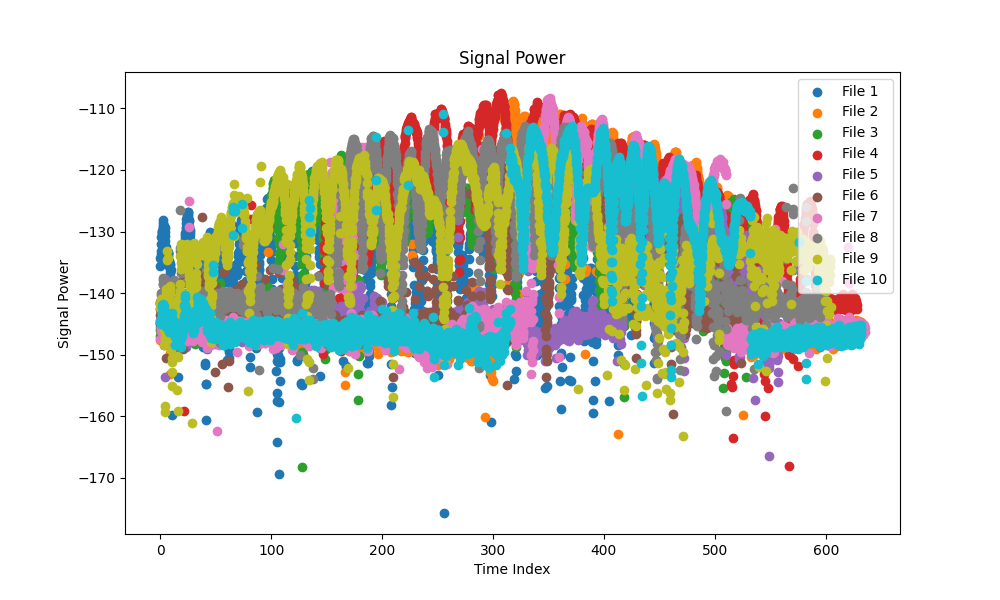

In [34]:
%matplotlib widget
import matplotlib.pyplot as plt
import noisy_moose as nm  # Ensure noisy_moose is installed
import json
import pickle
import numpy as np

# Define paths
data_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/output/'  # Update path as needed
label_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/Data-Pre/new_labels.json'

# Load labels
labels = json.loads(open(label_path).read())
file = [f for f in labels['3'] if f.startswith('GRBALPHA')]  # Filter files starting with 'GRBALPHA'
print(file)
print(len(file))

def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def unpickle(file):
    """Unpickles the given file from data_path."""
    try:
        with open(data_path + file + "_pickled.bin", 'rb') as f:
            dump = f.read()
        return pickle.loads(dump)
    except FileNotFoundError:
        print(f"File {file + '_pickled.bin'} not found. Skipping.")
        return None

def extract_features(prop_obj):
    """Extract multiple features from the given object."""
    if prop_obj is None:
        return None  # Skip if object is None

    # Calculate features
    pointing_error = calculate_pointing_error(
        prop_obj.station_obj.set_azimuth, 
        prop_obj.station_obj.set_elevation, 
        prop_obj.station_obj.azimuth, 
        prop_obj.station_obj.elevation
    )
    corrected_power = 10 * np.log10(prop_obj.noise_obj.signal_abs) - prop_obj.station_obj.fspl

    # Features
    features = [
        prop_obj.noise_obj.time,           # Time (0)
        prop_obj.noise_obj.signal_abs,     # Signal Power (1)
        prop_obj.station_obj.fspl,         # FSPL (2)
        prop_obj.station_obj.dist,         # Distance (3)
        prop_obj.station_obj.set_azimuth,  # Target azimuth (4)
        prop_obj.station_obj.set_elevation,# Target elevation (5)
        pointing_error,                    # Pointing error (6)
        prop_obj.noise_obj.noise,          # Noise power in W/Hz (7)
        corrected_power,                   # FSPL corrected signal power (8)
    ]

    # Find the maximum length
    max_length = max(len(feature) for feature in features)

    # Pad all features to the maximum length
    padded_features = [
        np.pad(feature, (0, max_length - len(feature)), constant_values=np.nan)
        for feature in features
    ]

    # Stack features column-wise
    return np.vstack(padded_features)


# Collect and process data
data_list = []
for f in file[:30]:  # Go through all files
    data: nm.prepping = unpickle(f)
    if data is not None:
        features = extract_features(data)
        if features is not None:
            data_list.append(features)

# Determine maximum length for padding
max_length = max(features.shape[1] for features in data_list)

# Pad the data for each file
padded_data = [
    np.pad(features, ((0, 0), (0, max_length - features.shape[1])), constant_values=np.nan) #all the ones which are not long enough are padded with nan, not ZERO or interpolated.
    for features in data_list
]

# Convert to a 3D numpy array: (file index, feature index, time index)
BAM = np.array(padded_data, dtype=np.float32)
print(f"BAM shape: {BAM.shape} (files, features, time)")

# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i+1}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()



C:\Users\StoreElberg\AppData\Local\Temp\ipykernel_25940\1362713598.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


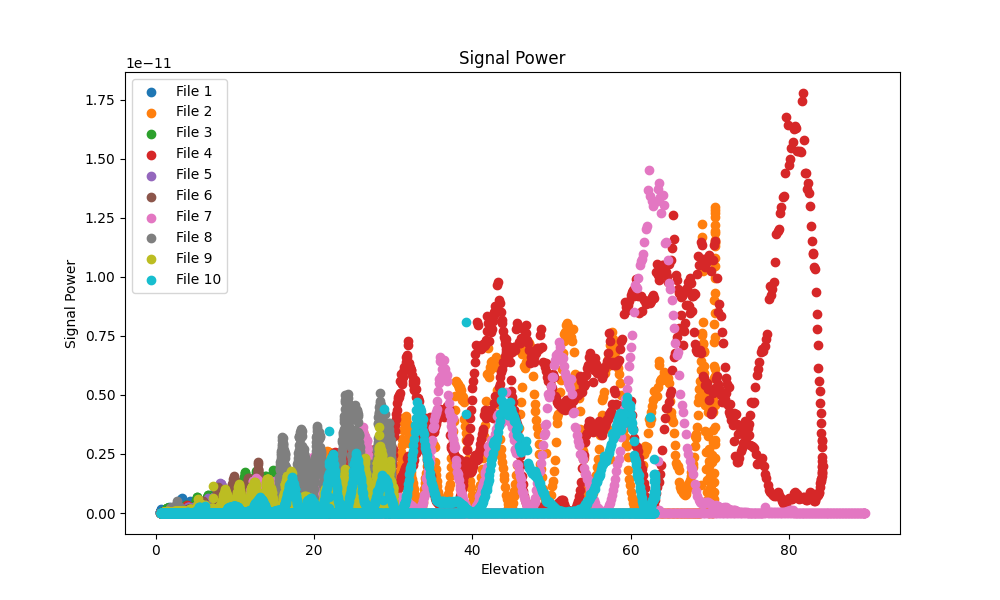

In [32]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 5], BAM[i, 1], label=f'File {i+1}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Elevation')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

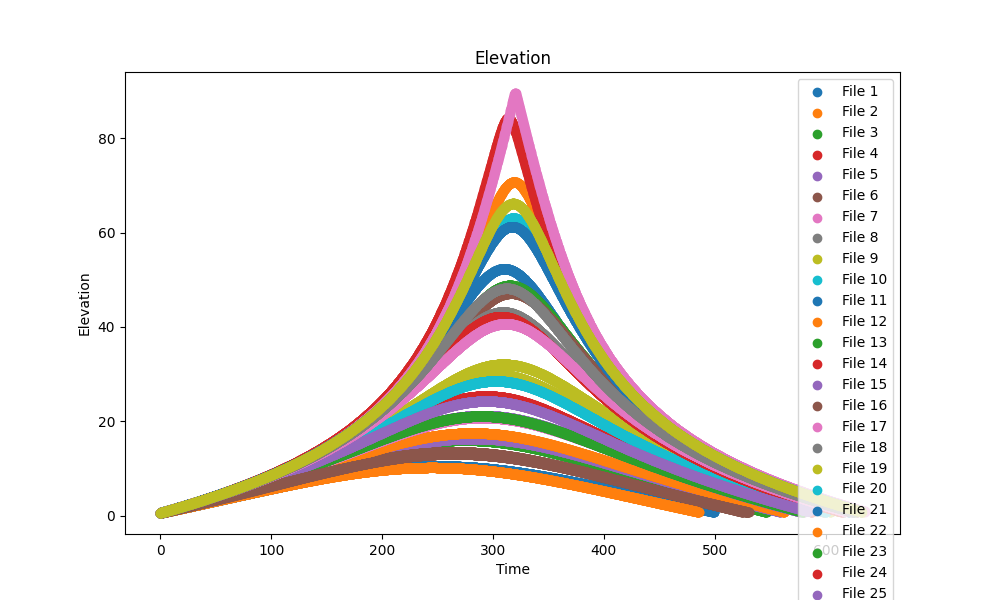

In [30]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(29):
    plt.scatter(BAM[i, 0], BAM[i, 5], label=f'File {i+1}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time')
plt.ylabel('Elevation')
plt.title('Elevation')
plt.legend()
plt.show()

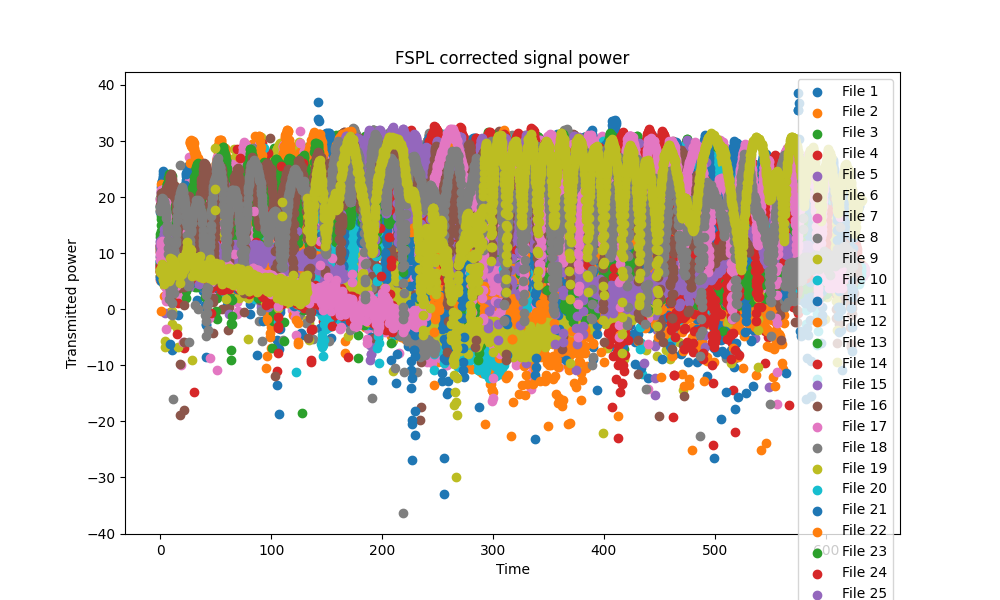

In [33]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(29):
    plt.scatter(BAM[i, 0], BAM[i, 8], label=f'File {i+1}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time')
plt.ylabel('Transmitted power')
plt.title('FSPL corrected signal power')
plt.legend()
plt.show()